<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/PCA-XGBoost-02/Instacart_2017_PCA_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Garbage Collector to free up memory
import gc                         
gc.enable()

cluster_count = 3

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/9-Projects/1-ML-Instacart


In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
orders = pd.read_csv("orders_50.csv")
order_products_prior = pd.read_csv("op_prior_50.csv")
order_products_train = pd.read_csv("op_train_50.csv")
# orders = pd.read_csv("orders_100.csv")
# order_products_prior = pd.read_csv("op_prior_100.csv")
# order_products_train = pd.read_csv("op_train_100.csv")
# orders = pd.read_csv("orders.csv")
# order_products_prior = pd.read_csv("order_products__prior.csv")
# order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (831792, 7)
products:  (49688, 4)
order_products_prior:  (7882503, 4)
order_products_train:  (334239, 4)


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831792 entries, 0 to 831791
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                831792 non-null  int64  
 1   user_id                 831792 non-null  int64  
 2   eval_set                831792 non-null  object 
 3   order_number            831792 non-null  int64  
 4   order_dow               831792 non-null  int64  
 5   order_hour_of_day       831792 non-null  int64  
 6   days_since_prior_order  781793 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 44.4+ MB


In [4]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7882503 entries, 0 to 7882502
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 240.6 MB


In [5]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')


orders['order_dow'] = orders['order_dow'].astype('int8')
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype('int8')
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('float16')
orders['user_id'] = orders['user_id'].astype('int32')
orders['order_id'] = orders['order_id'].astype('int32')
order_products_prior['order_id'] = order_products_prior['order_id'].astype('int32')
order_products_prior['product_id'] = order_products_prior['product_id'].astype('int16')
order_products_prior['add_to_cart_order'] = order_products_prior['add_to_cart_order'].astype('int8')
order_products_prior['reordered'] = order_products_prior['reordered'].astype('int8')

In [6]:
print('orders.shape =', orders.shape)
orders.head()

orders.shape = (831792, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
order_prior = pd.merge(order_products_prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
991482,431534,196,1,1,1,prior,5,4,15,28.0
991483,431534,12427,2,1,1,prior,5,4,15,28.0
991484,431534,10258,3,1,1,prior,5,4,15,28.0
991485,431534,25133,4,1,1,prior,5,4,15,28.0
991486,431534,10326,5,0,1,prior,5,4,15,28.0


In [8]:
_mt = pd.merge(order_products_prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
_mt = pd.merge(_mt,departments,on=['department_id','department_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,6,15873,2,0,Dryer Sheets Geranium Scent,75,17,22352,prior,4,1,12,30.0,household,laundry
1,125669,15873,5,0,Dryer Sheets Geranium Scent,75,17,11895,prior,2,3,14,7.0,household,laundry
2,258957,15873,8,0,Dryer Sheets Geranium Scent,75,17,4082,prior,1,6,8,NaN,household,laundry
3,800020,15873,8,0,Dryer Sheets Geranium Scent,75,17,28162,prior,8,1,16,13.0,household,laundry
4,954344,15873,5,0,Dryer Sheets Geranium Scent,75,17,38545,prior,2,6,15,6.0,household,laundry
5,1402169,15873,1,1,Dryer Sheets Geranium Scent,75,17,26431,prior,31,5,12,4.0,household,laundry
6,1426347,15873,3,0,Dryer Sheets Geranium Scent,75,17,10830,prior,20,3,11,29.0,household,laundry
7,1426347,11162,10,0,Bac-Out Stain + Odor Remover Live Enzyme Cultu...,75,17,10830,prior,20,3,11,29.0,household,laundry
8,1451247,15873,4,0,Dryer Sheets Geranium Scent,75,17,34910,prior,33,0,15,5.0,household,laundry
9,1451247,11675,3,0,Lemon Verbena 4x Concentrated Laundry Detergent,75,17,34910,prior,33,0,15,5.0,household,laundry


In [9]:
mt['product_name'].value_counts()[0:10]

Banana                    115371
Bag of Organic Bananas     92533
Organic Strawberries       63994
Organic Baby Spinach       59783
Strawberries               34878
Limes                      34034
Organic Raspberries        34000
Organic Whole Milk         33409
Organic Yellow Onion       28290
Organic Garlic             27278
Name: product_name, dtype: int64

In [10]:
mt['department'].value_counts()[0:10]

produce            1484889
dairy eggs          861482
snacks              451826
beverages           423339
frozen              367285
pantry              302432
bakery              199421
canned goods        186325
deli                178173
dry goods pasta     137431
Name: department, dtype: int64

In [11]:
len(mt['product_name'].unique())

30953

In [12]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     590342
fresh vegetables                 523866
packaged vegetables fruits       266328
yogurt                           218212
milk                             168877
packaged cheese                  163626
water seltzer sparkling water    125853
chips pretzels                   114190
bread                            105184
soy lactosefree                   94996
Name: aisle, dtype: int64

PCA

In [13]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
# cust_prod = pd.crosstab(mt['department_id'], mt['user_id'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,0,2,0,31
3,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,14


In [14]:
cust_prod.shape

(49948, 134)

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [16]:
ps = pd.DataFrame(pca_samples)
print('ps.shape =', ps.shape)
ps.head(8)

ps.shape = (49948, 4)


,0,1,2,3
0,-14.738253,2.703738,-1.557978,-1.292984
1,0.544502,20.516299,17.815614,8.552086
2,-7.918620,2.846710,-5.035370,-1.088584
3,-18.452461,-0.122752,-0.852732,0.863787
4,-11.219392,-1.859126,0.478458,2.511189
5,-17.541733,-2.392497,-0.153061,1.442039
6,7.099970,-0.182826,-5.157275,-3.420878
7,-6.955972,-12.789088,2.248273,2.236493


(49948, 2)
           1         3
0   2.703738 -1.292984
1  20.516299  8.552086
2   2.846710 -1.088584
3  -0.122752  0.863787
4  -1.859126  2.511189


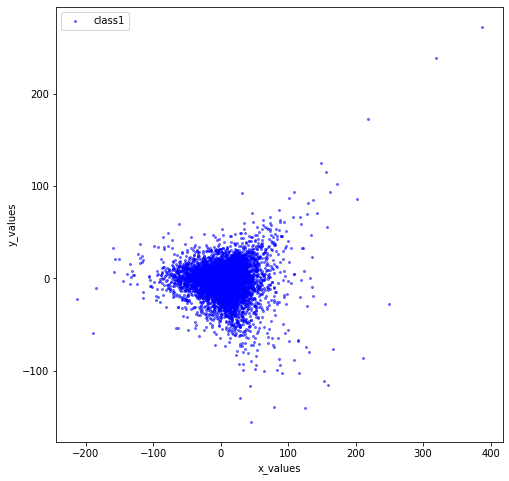

In [17]:
c1, c2 = 1, 3
tocluster = pd.DataFrame(ps[[c1,c2]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[c1], tocluster[c2], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [18]:
# plot_pca(4, 1)

In [19]:
# plot_pca(0, 1)

In [20]:
# plot_pca(1,2)

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=cluster_count,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ -0.12031683   0.17819805]
 [ 34.13521656  -2.95461487]
 [-32.13038482  -0.2644166 ]]


In [22]:
print (c_preds[0:100])
print('c_preds.shape =', c_preds.shape)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0]
c_preds.shape = (49948,)


['orange', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


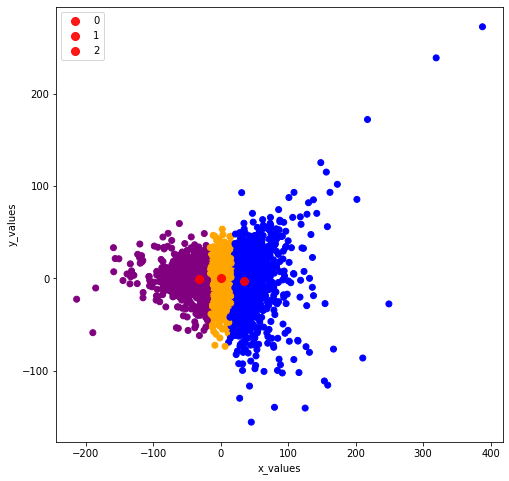

In [23]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[c1],tocluster[c2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [24]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,2,0,31,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


(49948, 135)


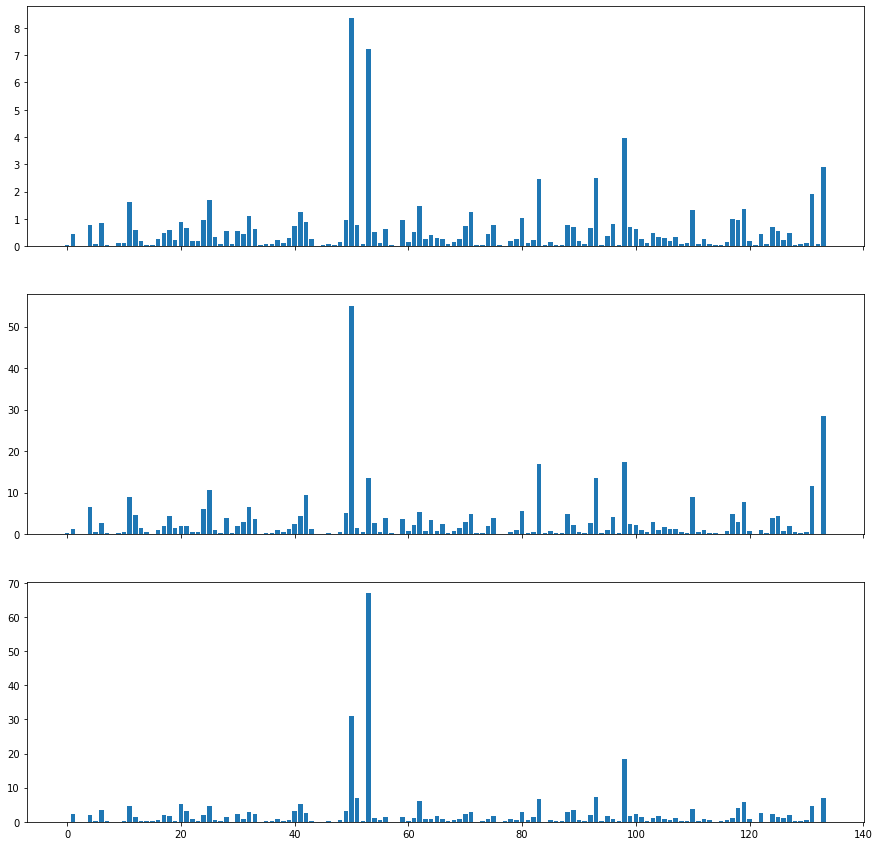

In [25]:
print (clust_prod.shape)
f,arr = plt.subplots(3,1,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)

c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[2].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)

# c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
# arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)

plt.show()

In [26]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     8.366033
fresh vegetables                 7.221074
packaged vegetables fruits       3.955719
yogurt                           2.893298
packaged cheese                  2.482183
milk                             2.452040
water seltzer sparkling water    1.906880
chips pretzels                   1.700656
bread                            1.601601
frozen produce                   1.464355
dtype: float64

In [27]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     55.071056
yogurt                           28.400241
packaged vegetables fruits       17.349659
milk                             16.959855
packaged cheese                  13.527900
fresh vegetables                 13.492975
water seltzer sparkling water    11.542754
chips pretzels                   10.666399
energy granola bars               9.503011
refrigerated                      9.013248
dtype: float64

In [28]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              66.915453
fresh fruits                  31.073625
packaged vegetables fruits    18.269417
packaged cheese                7.389563
yogurt                         7.003236
fresh herbs                    6.846278
milk                           6.603964
frozen produce                 5.965615
soy lactosefree                5.744337
eggs                           5.206311
dtype: float64

In [29]:
# c3.sort_values(ascending=False)[10:15]

In [30]:
clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,2,0,31,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [31]:
clust_prod = clust_prod.reset_index()
clust_prod.head()

aisle,user_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,3,0,0,0,0,1,0,0,...,1,1,0,0,0,0,2,0,31,1
2,3,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [32]:
user_clusters = clust_prod[['user_id','cluster']]
user_clusters.head()

aisle,user_id,cluster
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [33]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (7882503, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


1. USER PREDICTORS




In [34]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape = (49999, 1)
total users in the prior dataset = 49999


,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [35]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [36]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (49999, 2)


,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [37]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (49999, 3)


,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


2. PRODUCT PREDICTORS

In [38]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (46877, 2)


,product_id,p_total_purchases
0,-32768,137
1,-32767,1
2,-32766,4
3,-32765,146
4,-32764,25


In [39]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (6378825, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [40]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (4781, 2)


,product_id,p_reorder_ratio
0,-32755,0.498741
1,-32752,0.477695
2,-32744,0.606414
3,-32708,0.609635
4,-32705,0.711111


In [41]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (46877, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,-32768,137,NaN
1,-32767,1,NaN
2,-32766,4,NaN
3,-32765,146,NaN
4,-32764,25,NaN


In [42]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,-32768,137,0.0
1,-32767,1,0.0
2,-32766,4,0.0
3,-32765,146,0.0
4,-32764,25,0.0


3. USER-PRODUCT PREDICTORS

In [43]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       -29585                     1
        -26608                     1
        -25879                     1
        -23749                     1
        -19387                     3

In [44]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (3225069, 3)


,user_id,product_id,uxp_total_bought
0,1,-29585,1
1,1,-26608,1
2,1,-25879,1
3,1,-23749,1
4,1,-19387,3


In [45]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (3225069, 1)


Times_Bought_N
user_id product_id                
1       -29585                   1
        -26608                   1
        -25879                   1
        -23749                   1
        -19387                   3

In [46]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (49999, 2)


,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [47]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (3225069, 3)


,user_id,product_id,first_order_number
0,1,-29585,10
1,1,-26608,10
2,1,-25879,10
3,1,-23749,5
4,1,-19387,8


In [48]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (3225069, 4)


,user_id,total_orders,product_id,first_order_number
0,1,10,-29585,10
1,1,10,-26608,10
2,1,10,-25879,10
3,1,10,-23749,5
4,1,10,-19387,8


In [49]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (3225069, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,-29585,10,1
1,1,10,-26608,10,1
2,1,10,-25879,10,1
3,1,10,-23749,5,6
4,1,10,-19387,8,3


In [50]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (3225069, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,-29585,1,10,10,1
1,1,-26608,1,10,10,1
2,1,-25879,1,10,10,1
3,1,-23749,1,10,5,6
4,1,-19387,3,10,8,3


In [51]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,-29585,1,10,10,1,1.000000
1,1,-26608,1,10,10,1,1.000000
2,1,-25879,1,10,10,1,1.000000
3,1,-23749,1,10,5,6,0.166667
4,1,-19387,3,10,8,3,1.000000


In [52]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (3225069, 3)


,user_id,product_id,uxp_reorder_ratio
0,1,-29585,1.000000
1,1,-26608,1.000000
2,1,-25879,1.000000
3,1,-23749,0.166667
4,1,-19387,1.000000


In [53]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [54]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (3225069, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,-29585,1,1.000000
1,1,-26608,1,1.000000
2,1,-25879,1,1.000000
3,1,-23749,1,0.166667
4,1,-19387,3,1.000000


MERGE ALL FEATURES

In [55]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (3225069, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,-29585,1,1.000000,10,0.694915
1,1,-26608,1,1.000000,10,0.694915
2,1,-25879,1,1.000000,10,0.694915
3,1,-23749,1,0.166667,10,0.694915
4,1,-19387,3,1.000000,10,0.694915


In [56]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (3225069, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,-29585,1,1.000000,10,0.694915,13760,0.751962
1,1,-26608,1,1.000000,10,0.694915,3285,0.828919
2,1,-25879,1,1.000000,10,0.694915,1162,0.758176
3,1,-23749,1,0.166667,10,0.694915,8590,0.651804
4,1,-19387,3,1.000000,10,0.694915,2032,0.804134


In [57]:
# del op, user, prd, uxp
del user, prd, uxp
gc.collect()

200

TRAIN DF

In [58]:
print('orders.shape =', orders.shape)
orders['eval_set'].unique()

orders.shape = (831792, 7)


['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [59]:
print('op.shape =', op.shape)
op = op.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op.head(10)

op.shape = (7882503, 10)


,user_id,product_id,reordered
0,1,196,0
1,1,14084,0
2,1,12427,0
3,1,26088,0
4,1,26405,0
5,1,196,1
6,1,10258,0
7,1,12427,1
8,1,13176,0
9,1,26088,1


In [60]:
op = op.groupby(['user_id','product_id'])['reordered'].sum()

op = op.reset_index()
# op3 = op3[op3['new_reorder'] > 0]

# new_reorder = np.where(op3["new_reorder"] > 0, 1, 0)
op['reordered'] = op['reordered'].apply(lambda x: 0 if x == 0 else 1)
op.head(20)
op.shape

(3225069, 3)

In [61]:
opjoin = op.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin.shape =', opjoin.shape)

opjoin.shape = (3225069, 9)


In [62]:
del op

In [63]:
# opjoin.head(40)

In [64]:
opjoin['reordered'].unique()

array([0, 1])

In [65]:
opjoin = opjoin.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [66]:
opjoin = opjoin.merge(user_clusters, on='user_id', how='left')
opjoin.head()

,user_id,product_id,reordered,uxp_reorder_ratio,u_reordered_ratio,p_reorder_ratio,cluster
0,1,-29585,0,1.000000,0.694915,0.751962,0.0
1,1,-26608,0,1.000000,0.694915,0.828919,0.0
2,1,-25879,0,1.000000,0.694915,0.758176,0.0
3,1,-23749,0,0.166667,0.694915,0.651804,0.0
4,1,-19387,1,1.000000,0.694915,0.804134,0.0


In [67]:
opjoin = opjoin.set_index(['user_id', 'product_id'])
opjoin.head(11)

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       -29585              0           1.000000           0.694915   
        -26608              0           1.000000           0.694915   
        -25879              0           1.000000           0.694915   
        -23749              0           0.166667           0.694915   
        -19387              1           1.000000           0.694915   
        -16301              1           0.666667           0.694915   
         196                1           1.000000           0.694915   
         10258              1           1.000000           0.694915   
         10326              0           0.166667           0.694915   
         12427              1           1.000000           0.694915   
         13032              1           0.333333           0.694915   

                    p_reorder_ratio  cluster  
user_id product_id                            
1       -29585             0.751962      0.0  
        -26608             0.828919      0.0  
        -25879             0.758176      0.0  
        -23749             0.651804      0.0  
        -19387             0.804134      0.0  
        -16301             0.773240      0.0  
         196               0.788264      0.0  
         10258             0.707889      0.0  
         10326             0.618852      0.0  
         12427             0.734552      0.0  
         13032             0.638540      0.0

In [68]:
opjoin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3225069 entries, (1, -29585) to (49999, 32734)
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   reordered          int64  
 1   uxp_reorder_ratio  float64
 2   u_reordered_ratio  float64
 3   p_reorder_ratio    float64
 4   cluster            float64
dtypes: float64(4), int64(1)
memory usage: 150.4 MB


In [69]:
opjoin.head(20)

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       -29585              0           1.000000           0.694915   
        -26608              0           1.000000           0.694915   
        -25879              0           1.000000           0.694915   
        -23749              0           0.166667           0.694915   
        -19387              1           1.000000           0.694915   
        -16301              1           0.666667           0.694915   
         196                1           1.000000           0.694915   
         10258              1           1.000000           0.694915   
         10326              0           0.166667           0.694915   
         12427              1           1.000000           0.694915   
         13032              1           0.333333           0.694915   
         13176              1           0.222222           0.694915   
         14084              0           0.100000           0.694915   
         17122              0           0.166667           0.694915   
         25133              1           1.000000           0.694915   
         26088              1           0.200000           0.694915   
         26405              1           0.200000           0.694915   
         30450              0           0.125000           0.694915   
2       -32744              1           0.642857           0.476923   
        -32260              1           0.181818           0.476923   

                    p_reorder_ratio  cluster  
user_id product_id                            
1       -29585             0.751962      0.0  
        -26608             0.828919      0.0  
        -25879             0.758176      0.0  
        -23749             0.651804      0.0  
        -19387             0.804134      0.0  
        -16301             0.773240      0.0  
         196               0.788264      0.0  
         10258             0.707889      0.0  
         10326             0.618852      0.0  
         12427             0.734552      0.0  
         13032             0.638540      0.0  
         13176             0.833454      0.0  
         14084             0.812729      0.0  
         17122             0.655302      0.0  
         25133             0.737166      0.0  
         26088             0.556082      0.0  
         26405             0.395189      0.0  
         30450             0.594628      0.0  
2       -32744             0.606414      1.0  
        -32260             0.000000      1.0

TEST DF 

In [70]:
order_products_train = order_products_train[order_products_train['reordered']==1]
print('order_products_train.shape =', order_products_train)
op_test = orders.merge(order_products_train, on='order_id', how='inner')
print('op_test.shape', op_test.shape)
op_test.head(20)

order_products_train.shape =         order_id  product_id  add_to_cart_order  reordered
3             38       21616                  4          1
9             96       20574                  1          1
11            96       40706                  3          1
13            96       27966                  5          1
14            96       24489                  6          1
...          ...         ...                ...        ...
334230   3420996       24035                  3          1
334233   3420996       14947                  6          1
334234   3420996        2086                  7          1
334236   3420996       27423                  9          1
334237   3420996       12125                 10          1

[201191 rows x 4 columns]
op_test.shape (201191, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1
5,1187899,1,train,11,4,8,14.0,10258,6,1
6,1187899,1,train,11,4,8,14.0,13032,7,1
7,1187899,1,train,11,4,8,14.0,26088,8,1
8,1187899,1,train,11,4,8,14.0,49235,10,1
9,1187899,1,train,11,4,8,14.0,46149,11,1


In [71]:
op_test = op_test.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op_test.head(15)

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
5,1,10258,1
6,1,13032,1
7,1,26088,1
8,1,49235,1
9,1,46149,1


In [72]:
op_test[op_test['user_id']==1]

,user_id,product_id,reordered
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1
5,1,10258,1
6,1,13032,1
7,1,26088,1
8,1,49235,1
9,1,46149,1


In [73]:
expected_y_df = op_test
expected_y_df = expected_y_df.rename(columns={"reordered": "expected_y"})
print('expected_y_df.shape =', expected_y_df.shape)
expected_y_df.head()

expected_y_df.shape = (201191, 3)


,user_id,product_id,expected_y
0,1,196,1
1,1,25133,1
2,1,38928,1
3,1,26405,1
4,1,39657,1


In [74]:
opjoin_test = op_test.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin_test.shape =', opjoin_test.shape)

opjoin_test.shape = (201191, 9)


In [75]:
opjoin_test = opjoin_test.drop('reordered', axis=1)
opjoin_test.head(12)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10.0,1.000000,10.0,0.694915,9271.0,0.788264
1,1,25133,8.0,1.000000,10.0,0.694915,1461.0,0.737166
2,1,38928,NaN,NaN,NaN,NaN,NaN,NaN
3,1,26405,2.0,0.200000,10.0,0.694915,291.0,0.395189
4,1,39657,NaN,NaN,NaN,NaN,NaN,NaN
5,1,10258,9.0,1.000000,10.0,0.694915,469.0,0.707889
6,1,13032,3.0,0.333333,10.0,0.694915,877.0,0.638540
7,1,26088,2.0,0.200000,10.0,0.694915,633.0,0.556082
8,1,49235,NaN,NaN,NaN,NaN,NaN,NaN
9,1,46149,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
opjoin_test = opjoin_test.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [77]:
opjoin_test = opjoin_test.merge(user_clusters, on='user_id', how='left')
opjoin_test.head()

,user_id,product_id,uxp_reorder_ratio,u_reordered_ratio,p_reorder_ratio,cluster
0,1,196,1.0,0.694915,0.788264,0.0
1,1,25133,1.0,0.694915,0.737166,0.0
2,1,38928,NaN,NaN,NaN,0.0
3,1,26405,0.2,0.694915,0.395189,0.0
4,1,39657,NaN,NaN,NaN,0.0


In [78]:
opjoin_test = opjoin_test.set_index(['user_id', 'product_id'])
opjoin_test.head(20)

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio  \
user_id product_id                                                          
1       196                  1.000000           0.694915         0.788264   
        25133                1.000000           0.694915         0.737166   
        38928                     NaN                NaN              NaN   
        26405                0.200000           0.694915         0.395189   
        39657                     NaN                NaN              NaN   
        10258                1.000000           0.694915         0.707889   
        13032                0.333333           0.694915         0.638540   
        26088                0.200000           0.694915         0.556082   
        49235                     NaN                NaN              NaN   
        46149                     NaN                NaN              NaN   
2       22963                0.285714           0.476923         0.665037   
        7963                 1.000000           0.476923         0.667869   
        16589                0.357143           0.476923         0.685029   
        32792                     NaN                NaN              NaN   
        41787                     NaN                NaN              NaN   
        22825                1.000000           0.476923         0.685913   
        24852                0.636364           0.476923         0.843054   
        45066                     NaN                NaN              NaN   
        5450                 0.166667           0.476923         0.668253   
        22559                0.166667           0.476923         0.550620   

                    cluster  
user_id product_id           
1       196             0.0  
        25133           0.0  
        38928           0.0  
        26405           0.0  
        39657           0.0  
        10258           0.0  
        13032           0.0  
        26088           0.0  
        49235           0.0  
        46149           0.0  
2       22963           1.0  
        7963            1.0  
        16589           1.0  
        32792           1.0  
        41787           1.0  
        22825           1.0  
        24852           1.0  
        45066           1.0  
        5450            1.0  
        22559           1.0

Build Model

In [79]:
import xgboost
from sklearn.model_selection import train_test_split
# data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
# data_train.head()

In [80]:
opjoin.head()

reordered  uxp_reorder_ratio  u_reordered_ratio  \
user_id product_id                                                    
1       -29585              0           1.000000           0.694915   
        -26608              0           1.000000           0.694915   
        -25879              0           1.000000           0.694915   
        -23749              0           0.166667           0.694915   
        -19387              1           1.000000           0.694915   

                    p_reorder_ratio  cluster  
user_id product_id                            
1       -29585             0.751962      0.0  
        -26608             0.828919      0.0  
        -25879             0.758176      0.0  
        -23749             0.651804      0.0  
        -19387             0.804134      0.0

In [81]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(opjoin.drop('reordered', axis=1), opjoin.reordered,
                                                    test_size=0.2, random_state=42)

[0]	train-logloss:0.677717
[10]	train-logloss:0.52064
[20]	train-logloss:0.455861
[30]	train-logloss:0.41758
[40]	train-logloss:0.383471
[50]	train-logloss:0.372492
[60]	train-logloss:0.360534
[70]	train-logloss:0.351186
[79]	train-logloss:0.345387


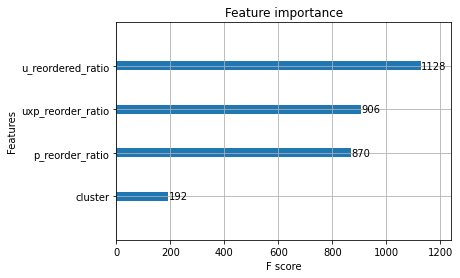

In [82]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [83]:
del [X_train, X_val, y_train, y_val]
gc.collect()

50

In [84]:
opjoin_test.head()

uxp_reorder_ratio  u_reordered_ratio  p_reorder_ratio  \
user_id product_id                                                          
1       196                       1.0           0.694915         0.788264   
        25133                     1.0           0.694915         0.737166   
        38928                     NaN                NaN              NaN   
        26405                     0.2           0.694915         0.395189   
        39657                     NaN                NaN              NaN   

                    cluster  
user_id product_id           
1       196             0.0  
        25133           0.0  
        38928           0.0  
        26405           0.0  
        39657           0.0

In [85]:
pred = xgboost.DMatrix(opjoin_test)

prediction = opjoin_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered_predicted"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered_predicted
0,196,1,1
1,25133,1,1
2,38928,1,0
3,26405,1,1
4,39657,1,0
...,...,...,...
201186,10644,49999,1
201187,26629,49999,1
201188,20980,49999,1
201189,7728,49999,1


In [86]:
tally = pd.merge(prediction, expected_y_df, on=['user_id', 'product_id'], how='inner')
tally.head()

,product_id,user_id,reordered_predicted,expected_y
0,196,1,1,1
1,25133,1,1,1
2,38928,1,0,1
3,26405,1,1,1
4,39657,1,0,1


In [87]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y
0,196,1,1,1
1,25133,1,1,1
2,38928,1,0,1
3,26405,1,1,1
4,39657,1,0,1
5,10258,1,1,1
6,13032,1,1,1
7,26088,1,1,1
8,49235,1,0,1
9,46149,1,0,1


In [88]:
compare = np.where(tally["reordered_predicted"] == tally["expected_y"], True, False)

tally['compare'] = compare
tally.head()

,product_id,user_id,reordered_predicted,expected_y,compare
0,196,1,1,1,True
1,25133,1,1,1,True
2,38928,1,0,1,False
3,26405,1,1,1,True
4,39657,1,0,1,False


In [89]:
tally.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201191 entries, 0 to 201190
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   product_id           201191 non-null  int64
 1   user_id              201191 non-null  int64
 2   reordered_predicted  201191 non-null  int64
 3   expected_y           201191 non-null  int64
 4   compare              201191 non-null  bool 
dtypes: bool(1), int64(4)
memory usage: 7.9 MB


In [90]:
true_count = tally['compare'].sum()
true_count

120119

In [91]:
false_count = len(tally['compare'])
false_count

201191

In [92]:
accuracy = (true_count/(len(tally['compare'])))*100
print('Accuracy =', accuracy, '%')

Accuracy = 59.70396290092499 %


In [93]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y,compare
0,196,1,1,1,True
1,25133,1,1,1,True
2,38928,1,0,1,False
3,26405,1,1,1,True
4,39657,1,0,1,False
5,10258,1,1,1,True
6,13032,1,1,1,True
7,26088,1,1,1,True
8,49235,1,0,1,False
9,46149,1,0,1,False
